<a href="https://colab.research.google.com/github/Dhruv-2020EE30592/EECE-5644/blob/main/Assignment-3/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os

import scipy.stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from mpl_toolkits.mplot3d import Axes3D

# Question 1

In [ ]:
# Generating samples

def generate_samples(N):
  P_L0 = 0.25
  P_L1 = 0.25
  P_L2 = 0.25
  P_L3 = 0.25

  mu_0 = [0, 0, 0]
  mu_1 = [3, 3, 3]
  mu_2 = [6, 6, 6]
  mu_3 = [9, 9, 9]
  sigma_0 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
  sigma_1 = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
  sigma_2 = [[3, 0, 0], [0, 3, 0], [0, 0, 3]]
  sigma_3 = [[4, 0, 0], [0, 4, 0], [0, 0, 4]]

  samples = np.zeros((N, 3))
  L_samples = np.random.choice([0, 1, 2, 3], size=N, p=[P_L0, P_L1, P_L2, P_L3])
  for i in range(N):
    if L_samples[i] == 0:
      samples[i] = np.random.multivariate_normal(mu_0, sigma_0)
    elif L_samples[i] == 1:
      samples[i] = np.random.multivariate_normal(mu_1, sigma_1)
    elif L_samples[i] == 2:
      samples[i] = np.random.multivariate_normal(mu_2, sigma_2)
    else:
      samples[i] = np.random.multivariate_normal(mu_3, sigma_3)

  return samples, L_samples

In [ ]:
# Visualize samples

def visualize_samples_3d(D_samples, L_samples, ax):
    ax.scatter(D_samples[L_samples == 0][:, 0], D_samples[L_samples == 0][:, 1], D_samples[L_samples == 0][:, 2], color='red', label='Class 0', alpha=0.3)
    ax.scatter(D_samples[L_samples == 1][:, 0], D_samples[L_samples == 1][:, 1], D_samples[L_samples == 1][:, 2], color='blue', label='Class 1', alpha=0.3)
    ax.scatter(D_samples[L_samples == 2][:, 0], D_samples[L_samples == 2][:, 1], D_samples[L_samples == 2][:, 2], color='green', label='Class 2', alpha=0.3)
    ax.scatter(D_samples[L_samples == 3][:, 0], D_samples[L_samples == 3][:, 1], D_samples[L_samples == 3][:, 2], color='black', label='Class 3', alpha=0.3)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()

In [ ]:
# Classification based on max posterior probability

def MAP_classifier(x):
  P_L0 = 0.25
  P_L1 = 0.25
  P_L2 = 0.25
  P_L3 = 0.25

  mu_0 = [0, 0, 0]
  mu_1 = [2, 2, 2]
  mu_2 = [4, 4, 4]
  mu_3 = [10, 10, 10]
  sigma_0 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
  sigma_1 = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
  sigma_2 = [[3, 0, 0], [0, 3, 0], [0, 0, 3]]
  sigma_3 = [[4, 0, 0], [0, 4, 0], [0, 0, 4]]

  post_L0 = P_L0*scipy.stats.multivariate_normal.pdf(x, mean=mu_0, cov=sigma_0)
  post_L1 = P_L1*scipy.stats.multivariate_normal.pdf(x, mean=mu_1, cov=sigma_1)
  post_L2 = P_L2*scipy.stats.multivariate_normal.pdf(x, mean=mu_2, cov=sigma_2)
  post_L3 = P_L3*scipy.stats.multivariate_normal.pdf(x, mean=mu_3, cov=sigma_3)

  return np.argmax(np.stack([post_L0, post_L1, post_L2, post_L3], axis=1), axis=1), np.stack([post_L0, post_L1, post_L2, post_L3], axis=1)

In [ ]:
# Confusion Matrix

def confusion_matrix(L_samples, D_samples):
  conf_matrix = np.zeros((4, 4))
  correct_assignments = 0
  total_samples = 0
  for i in range(4):
    for j in range(4):
      conf_matrix[i, j] = np.sum((L_samples == i) & (D_samples == j)) / np.sum(L_samples == i)
      total_samples += np.sum((L_samples == i) & (D_samples == j))
      if i == j:
        correct_assignments += np.sum((L_samples == i) & (D_samples == j))
  plt.figure(figsize=(6, 4))
  sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=[f'D={i}' for i in range(4)], yticklabels=[f'L={i}' for i in range(4)])
  plt.title('Confusion Matrix Heatmap')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()
  print(f'Accuracy: {correct_assignments/total_samples:.2f}')
  print(f'Minimum probability error: {1-correct_assignments/total_samples:.2f}')
  # return 1-correct_assignments/total_samples

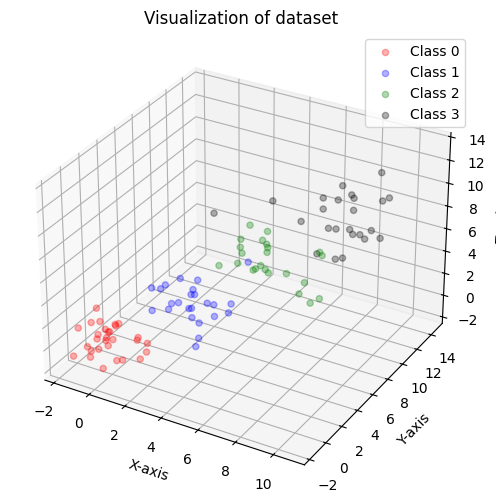

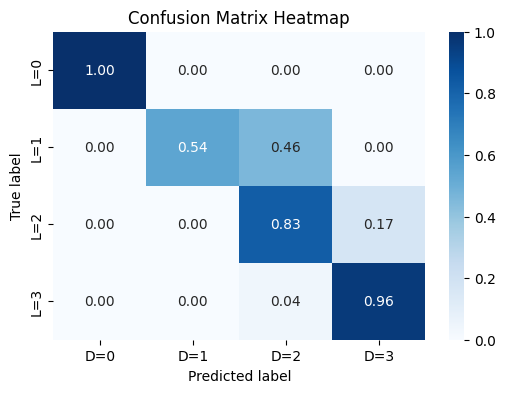

Accuracy: 0.84
Minimum probability error: 0.16


In [ ]:
np.random.seed(42)

D_100_train, L_100_train = generate_samples(100)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
visualize_samples_3d(D_100_train, L_100_train, ax1)
plt.title('Visualization of dataset')
plt.show()

LPred_100_train, LPredCont_100_train = MAP_classifier(D_100_train)
LPred_100_train = np.array(LPred_100_train).reshape(-1)

confusion_matrix(L_100_train, LPred_100_train)

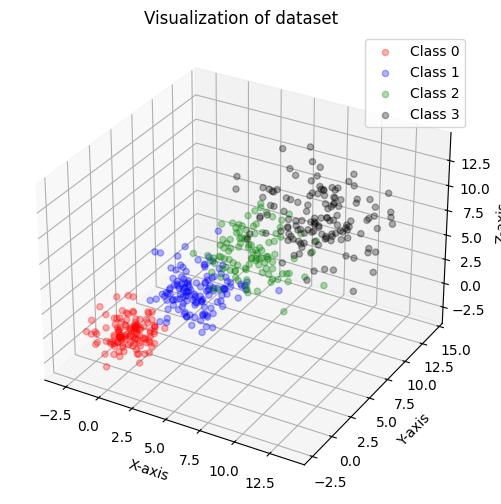

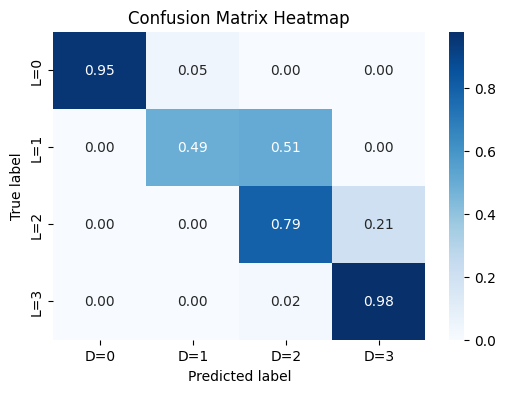

Accuracy: 0.80
Minimum probability error: 0.20


In [ ]:
D_500_train, L_500_train = generate_samples(500)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
visualize_samples_3d(D_500_train, L_500_train, ax1)
plt.title('Visualization of dataset')
plt.show()

LPred_500_train, LPredCont_500_train = MAP_classifier(D_500_train)
LPred_500_train = np.array(LPred_500_train).reshape(-1)

confusion_matrix(L_500_train, LPred_500_train)

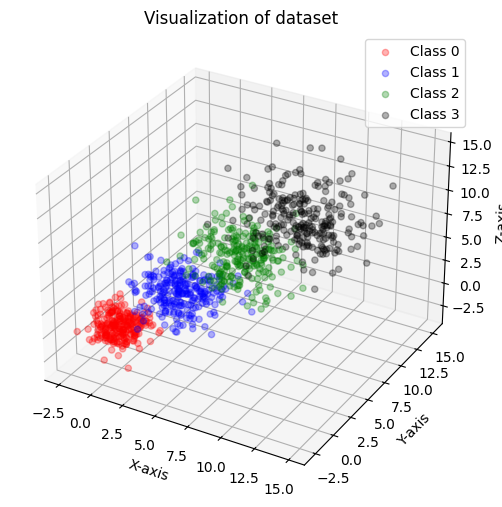

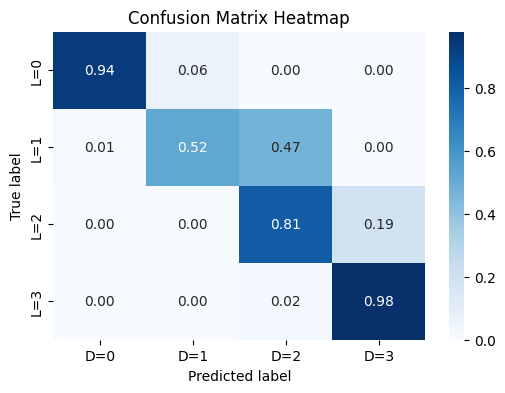

Accuracy: 0.81
Minimum probability error: 0.19


In [ ]:
D_1000_train, L_1000_train = generate_samples(1000)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
visualize_samples_3d(D_1000_train, L_1000_train, ax1)
plt.title('Visualization of dataset')
plt.show()

LPred_1000_train, LPredCont_1000_train = MAP_classifier(D_1000_train)
LPred_1000_train = np.array(LPred_1000_train).reshape(-1)

confusion_matrix(L_1000_train, LPred_1000_train)

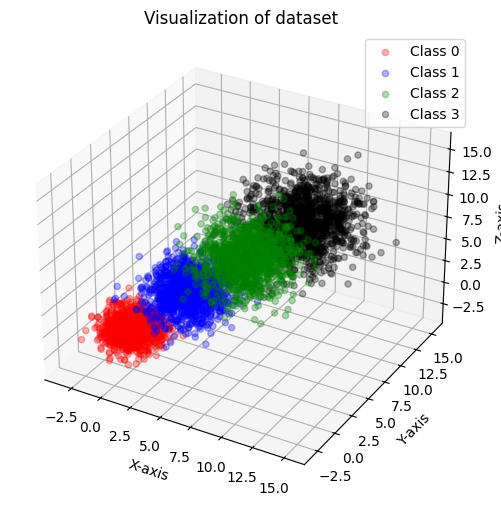

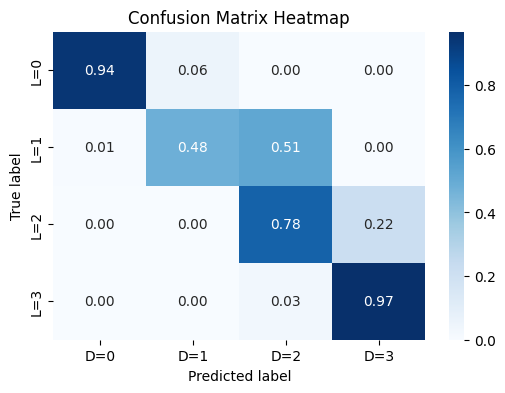

Accuracy: 0.79
Minimum probability error: 0.21


In [ ]:
D_5000_train, L_5000_train = generate_samples(5000)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
visualize_samples_3d(D_5000_train, L_5000_train, ax1)
plt.title('Visualization of dataset')
plt.show()

LPred_5000_train, LPredCont_5000_train = MAP_classifier(D_5000_train)
LPred_5000_train = np.array(LPred_5000_train).reshape(-1)

confusion_matrix(L_5000_train, LPred_5000_train)

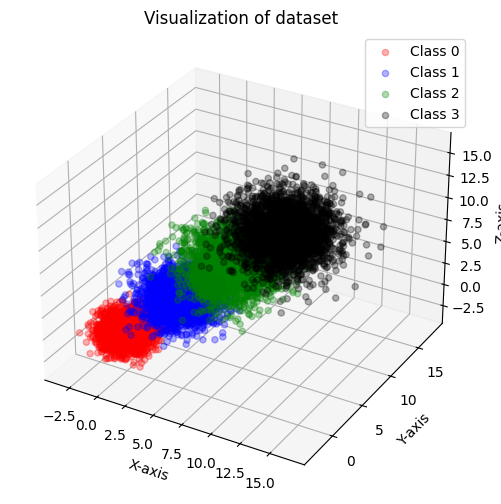

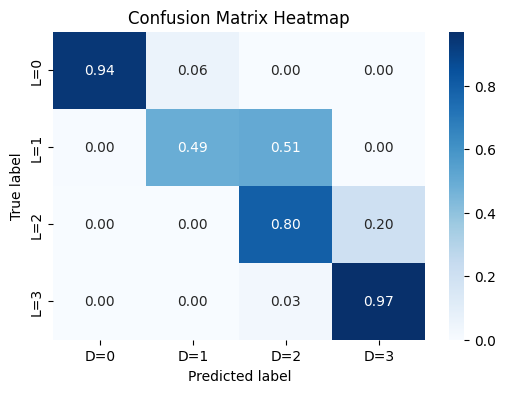

Accuracy: 0.80
Minimum probability error: 0.20


In [ ]:
D_10000_train, L_10000_train = generate_samples(10000)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
visualize_samples_3d(D_10000_train, L_10000_train, ax1)
plt.title('Visualization of dataset')
plt.show()

LPred_10000_train, LPredCont_10000_train = MAP_classifier(D_10000_train)
LPred_10000_train = np.array(LPred_10000_train).reshape(-1)

confusion_matrix(L_10000_train, LPred_10000_train)

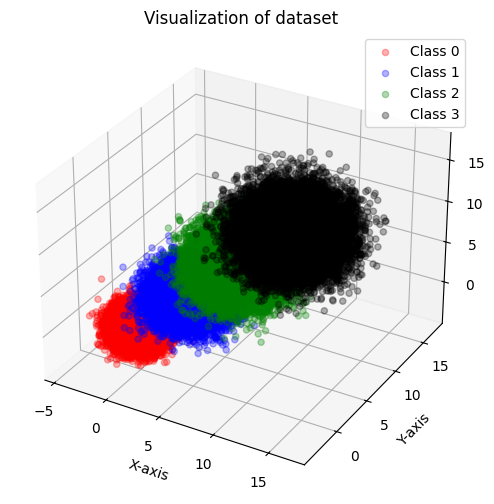

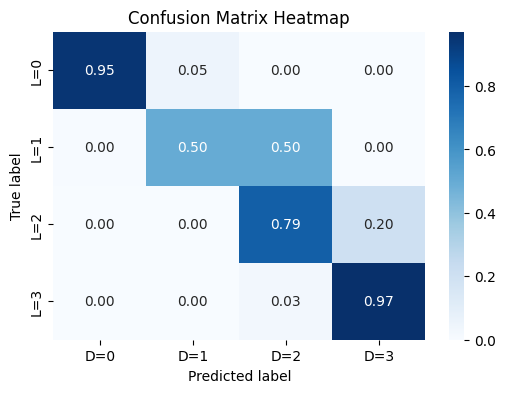

Accuracy: 0.80
Minimum probability error: 0.20


In [ ]:
D_100000_test, L_100000_test = generate_samples(100000)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
visualize_samples_3d(D_100000_test, L_100000_test, ax1)
plt.title('Visualization of dataset')
plt.show()

LPred_100000_test, LPredCont_100000_test = MAP_classifier(D_100000_test)
LPred_100000_test = np.array(LPred_100000_test).reshape(-1)

confusion_matrix(L_100000_test, LPred_100000_test)

In [ ]:
# Define the MLP model

class ISRU(nn.Module):
  def __init__(self, alpha=0.1):
    super(ISRU, self).__init__()
    self.alpha = alpha

  def forward(self, x):
    return x / torch.sqrt(1 + self.alpha * x**2)

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, activation):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, output_size)
    self.activation = activation
    self.isru = ISRU(alpha=0.1) # ISRU
    self.srelu = nn.Softplus() # Smooth ReLU
    self.elu = nn.ELU() # ELU

  def forward(self, x):
    x = self.l1(x)
    if self.activation == 'ISRU':
      x = self.isru(x)
    elif self.activation == 'Smooth ReLU':
      x = self.srelu(x)
    elif self.activation == 'ELU':
      x = self.elu(x)
    else:
      raise ValueError(f"Activation '{self.activation}' not supported. Choose from 'ISRU', 'Smooth ReLU', or 'ELU'.")
    x = self.l2(x)
    return x

def softmax(x):
  return torch.softmax(x, dim=1)

In [ ]:
# Cross-validation function to evaluate different numbers of perceptrons

def cross_validate(X, y, hidden_size_options, max_epochs = 150, n_splits=10, activation='ISRU'):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  best_size = None
  best_epoch = None
  best_accuracy = 0
  torch.manual_seed(42)
  epoch_accuracies = {hidden_size: [[] for _ in range(n_splits)] for hidden_size in hidden_size_options}

  for hidden_size in hidden_size_options:
    accuracies = []
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      X_train_tensor = torch.FloatTensor(X_train)
      y_train_tensor = torch.LongTensor(y_train)
      X_test_tensor = torch.FloatTensor(X_test)
      y_test_tensor = torch.LongTensor(y_test)

      model = MLP(input_size=X.shape[1], hidden_size=hidden_size, output_size=len(np.unique(y)), activation=activation)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)

      for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
          test_outputs = model(X_test_tensor)
          test_predictions = softmax(test_outputs)
          test_classes = torch.argmax(test_predictions, dim=1)
          accuracy = (test_classes == y_test_tensor).float().mean().item()
          accuracies.append(accuracy)
          epoch_accuracies[hidden_size][fold].append(accuracy)

  avg_epoch_accuracies = {hidden_size: [] for hidden_size in hidden_size_options}
  for hidden_size in hidden_size_options:
    fold_accuracies = epoch_accuracies[hidden_size]
    num_folds = len(fold_accuracies)
    for epoch in range(max_epochs):
      epoch_acc = np.mean([fold[epoch] for fold in fold_accuracies if len(fold) > epoch])
      avg_epoch_accuracies[hidden_size].append(epoch_acc)
  return avg_epoch_accuracies

def plot_avg_epoch_accs(avg_epoch_accuracies, max_epochs, start_epoch=1, end_epoch=None):
  if end_epoch is None or end_epoch > max_epochs:
    end_epoch = max_epochs
  plt.figure(figsize=(10, 6))
  best_hidden_size = None
  best_epoch = 0
  best_acc = 0
  for hidden_size, accuracies in avg_epoch_accuracies.items():
    epoch_range = range(start_epoch, end_epoch + 1)
    accuracy_range = accuracies[start_epoch - 1:end_epoch]
    plt.plot(epoch_range, accuracy_range, label=f'Hidden Size {hidden_size}')
    max_acc_in_range = max(accuracy_range)
    best_epoch_in_range = epoch_range[accuracy_range.index(max_acc_in_range)]
    if max_acc_in_range > best_acc:
      best_acc = max_acc_in_range
      best_epoch = best_epoch_in_range
      best_hidden_size = hidden_size
  plt.xlabel('Epoch')
  plt.ylabel('Average Validation Accuracy')
  plt.title('Average Validation Accuracy per Epoch for Different Hidden Sizes')
  plt.legend()
  plt.grid(True)
  plt.show()
  print(f'Best hidden size: {best_hidden_size}, Best epoch: {best_epoch}, Best accuracy: {best_acc:.4f}')

In [ ]:
def train_model(X, y):
  max_epochs = 500
  encoder = OneHotEncoder(sparse_output=False)
  y = encoder.fit_transform(y.reshape(-1, 1)).argmax(axis=1)

  hidden_size_options = list(range(40, 60, 5))
  for activation in ['ISRU', 'Smooth ReLU', 'ELU']:
    avg_epoch_accuracies = cross_validate(X, y, hidden_size_options, max_epochs=max_epochs, n_splits=10, activation=activation)
    print(f'Activation Function: {activation}')
    plot_avg_epoch_accs(avg_epoch_accuracies, max_epochs=max_epochs)

100 samples training dataset
Activation Function: ISRU


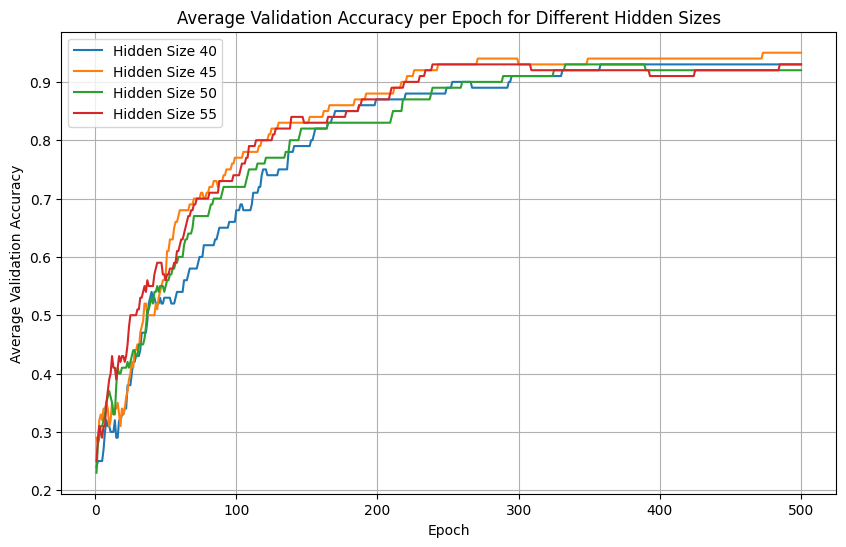

Best hidden size: 45, Best epoch: 473, Best accuracy: 0.9500
Activation Function: Smooth ReLU


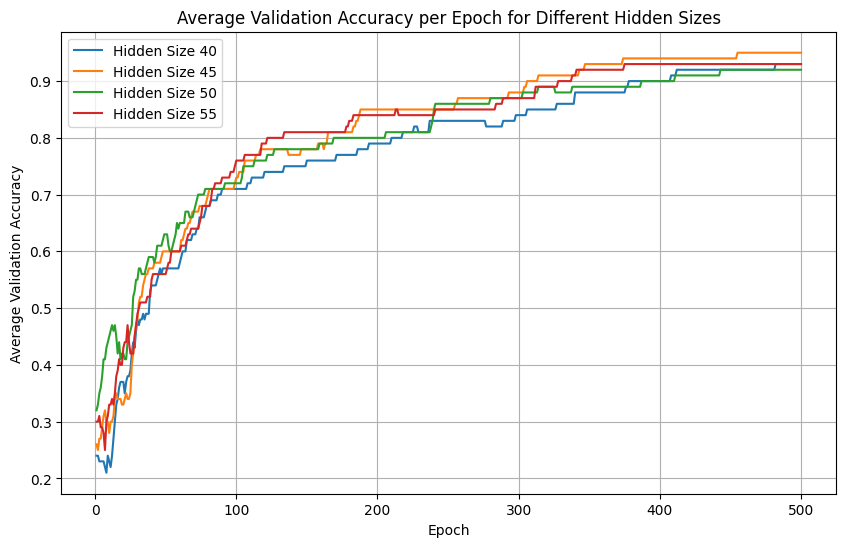

Best hidden size: 45, Best epoch: 455, Best accuracy: 0.9500
Activation Function: ELU


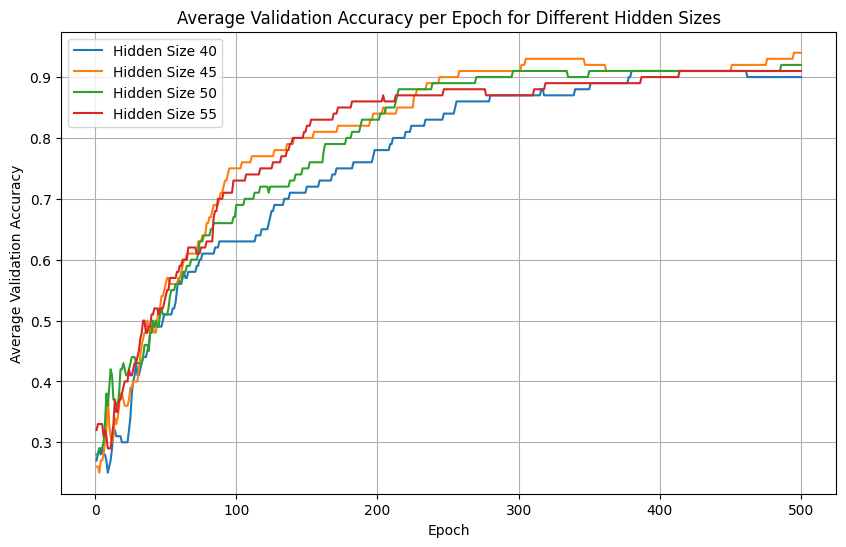

Best hidden size: 45, Best epoch: 495, Best accuracy: 0.9400
500 samples training dataset
Activation Function: ISRU


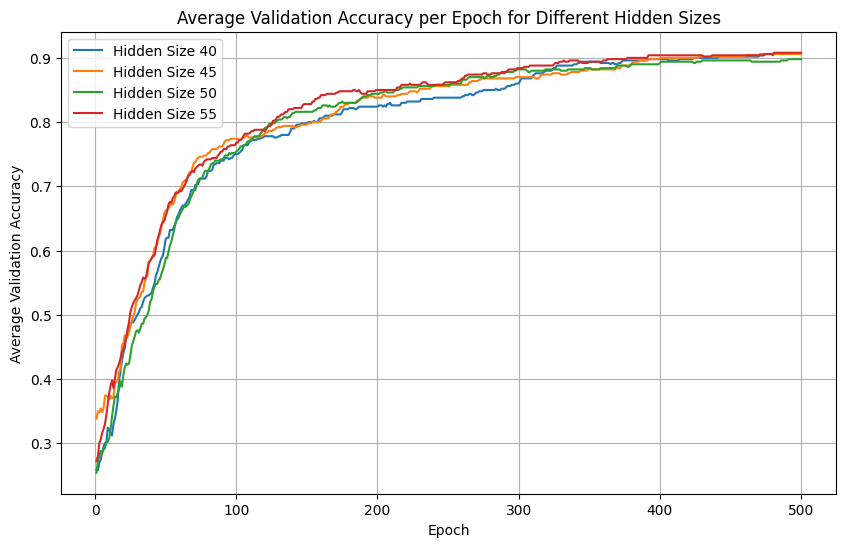

Best hidden size: 55, Best epoch: 481, Best accuracy: 0.9080
Activation Function: Smooth ReLU


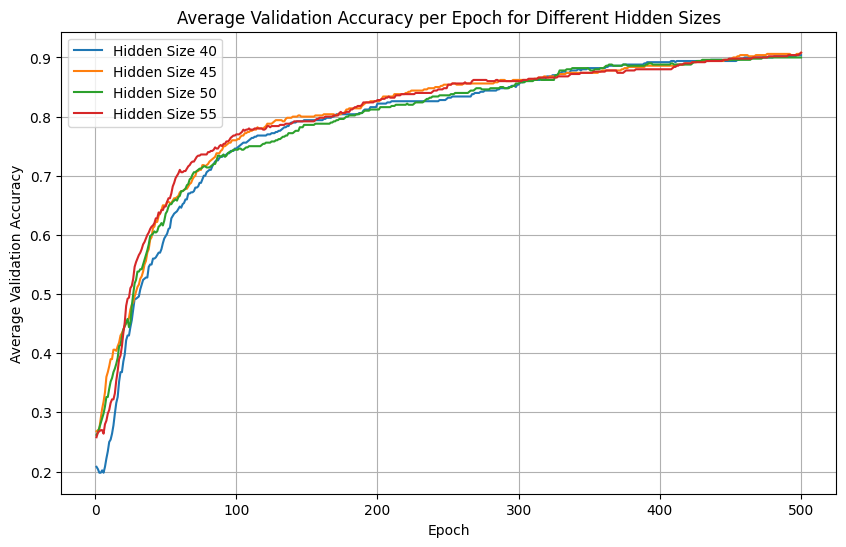

Best hidden size: 55, Best epoch: 500, Best accuracy: 0.9080
Activation Function: ELU


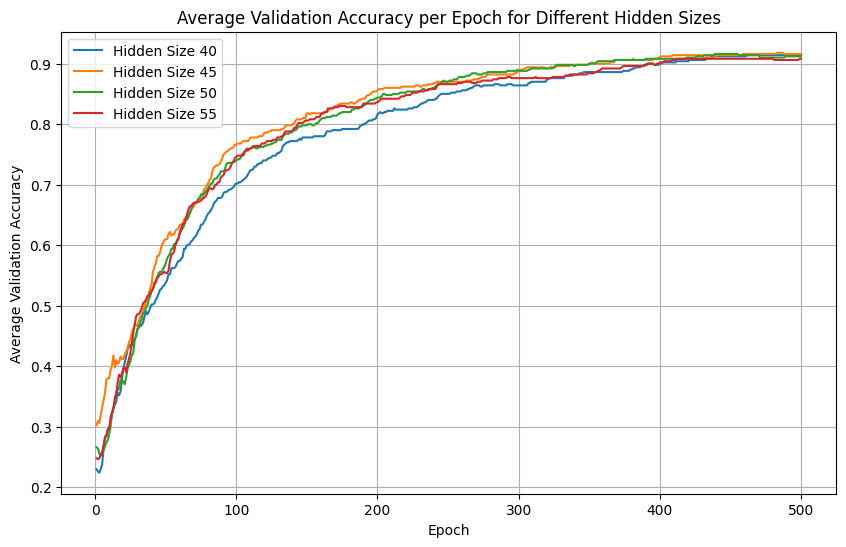

Best hidden size: 45, Best epoch: 483, Best accuracy: 0.9180
1000 samples training dataset
Activation Function: ISRU


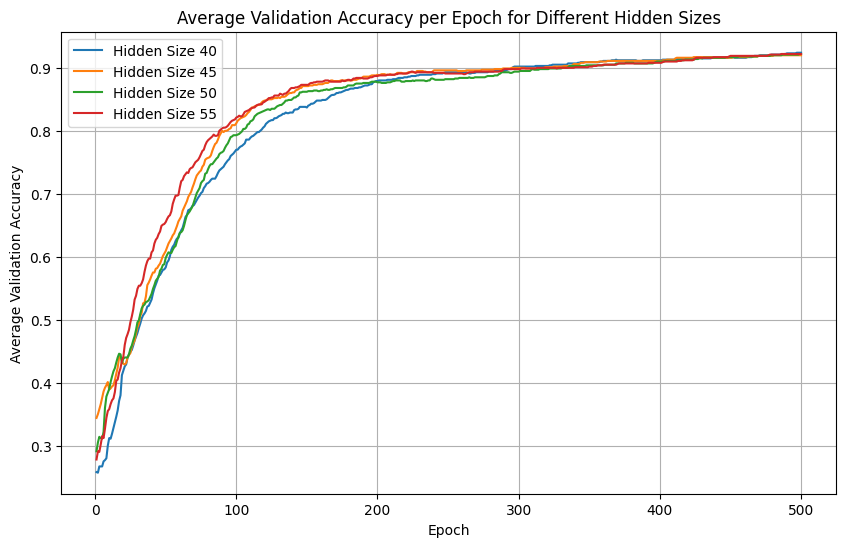

Best hidden size: 40, Best epoch: 497, Best accuracy: 0.9240
Activation Function: Smooth ReLU


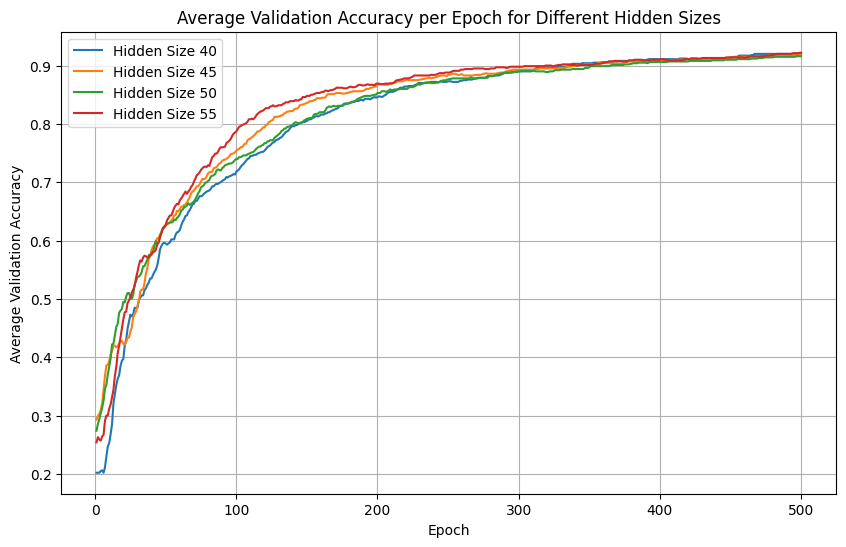

Best hidden size: 55, Best epoch: 499, Best accuracy: 0.9220
Activation Function: ELU


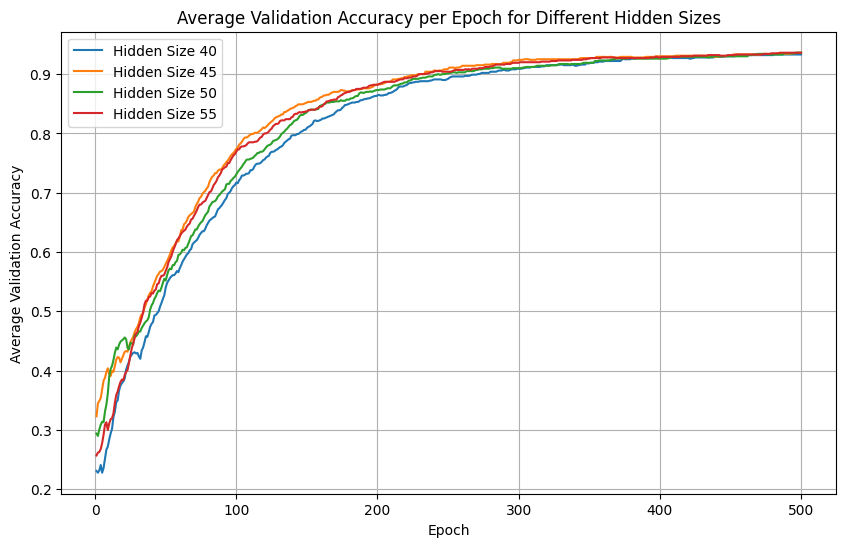

Best hidden size: 45, Best epoch: 497, Best accuracy: 0.9360
5000 samples training dataset
Activation Function: ISRU


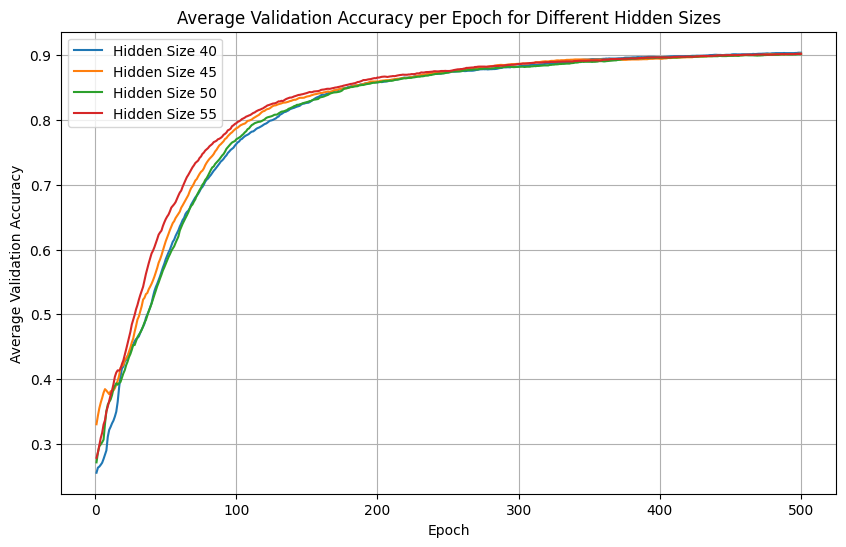

Best hidden size: 40, Best epoch: 498, Best accuracy: 0.9038
Activation Function: Smooth ReLU


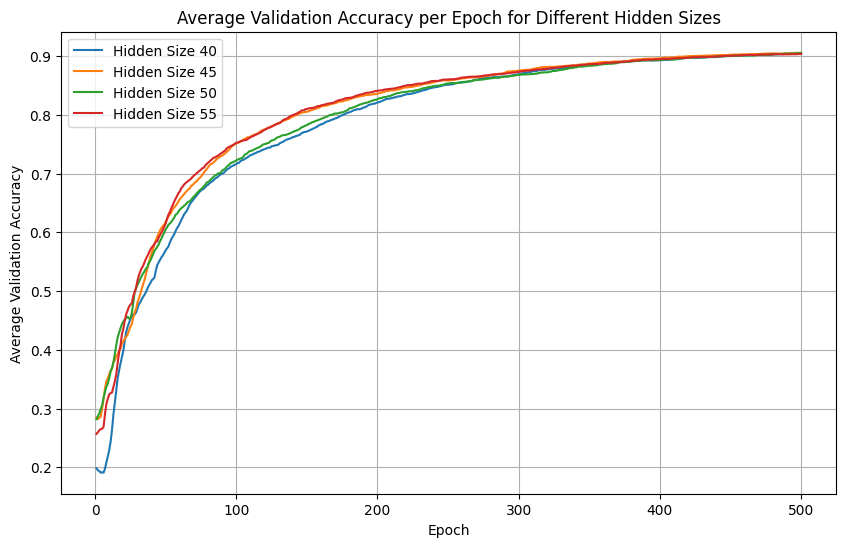

Best hidden size: 45, Best epoch: 500, Best accuracy: 0.9058
Activation Function: ELU


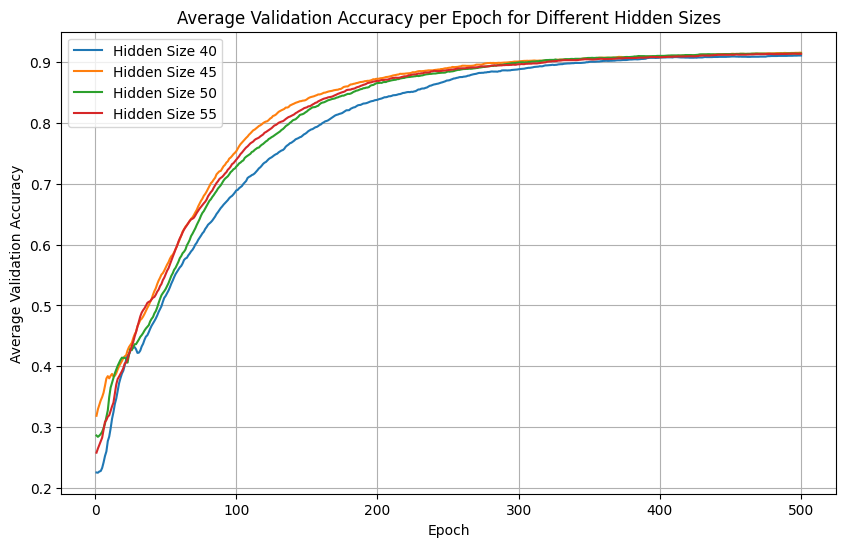

Best hidden size: 45, Best epoch: 499, Best accuracy: 0.9156
10000 samples training dataset
Activation Function: ISRU


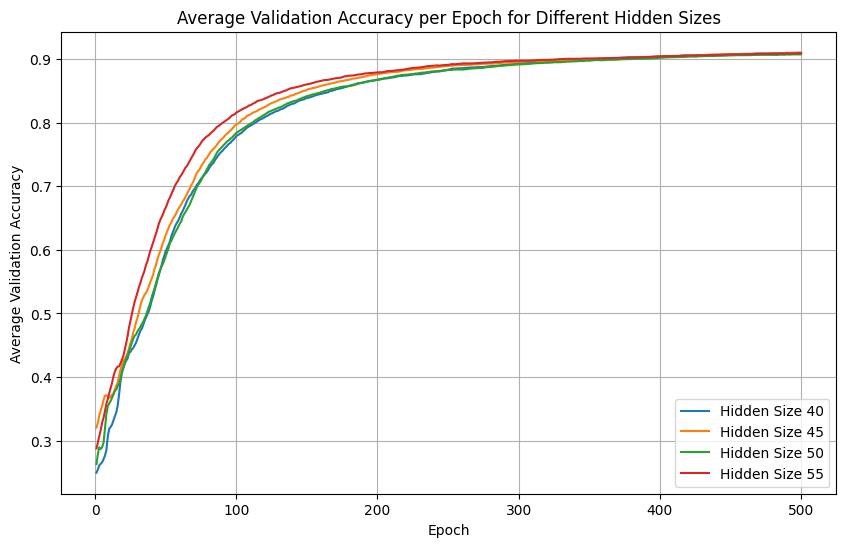

Best hidden size: 40, Best epoch: 498, Best accuracy: 0.9101
Activation Function: Smooth ReLU


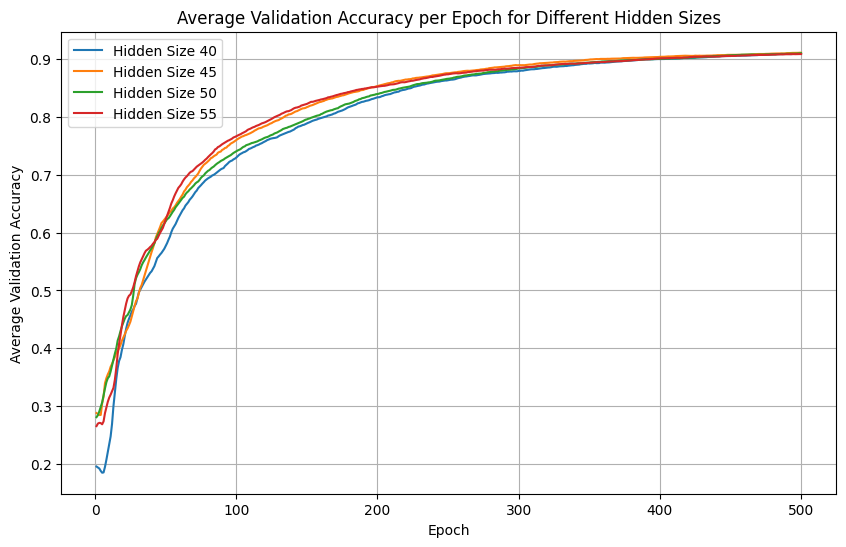

Best hidden size: 45, Best epoch: 499, Best accuracy: 0.9114
Activation Function: ELU


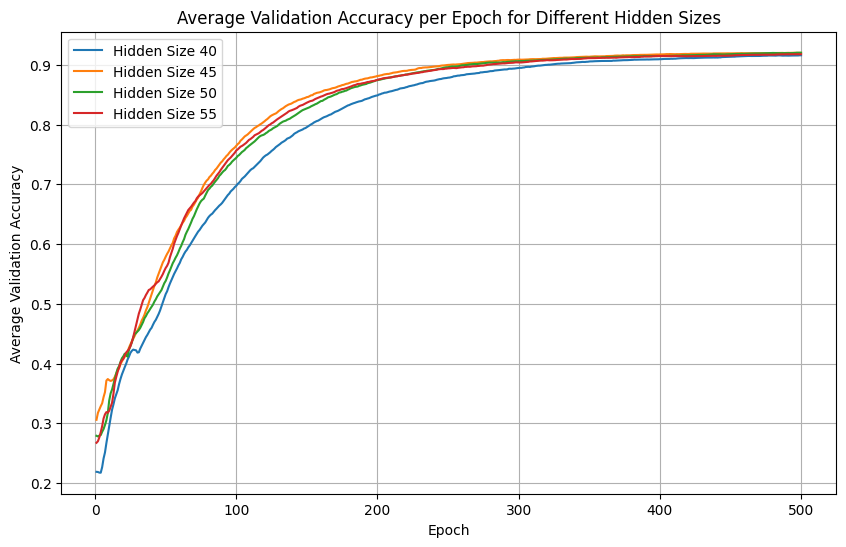

Best hidden size: 50, Best epoch: 497, Best accuracy: 0.9204


In [ ]:
print(f'100 samples training dataset')
train_model(D_100_train, L_100_train)
print(f'500 samples training dataset')
train_model(D_500_train, L_500_train)
print(f'1000 samples training dataset')
train_model(D_1000_train, L_1000_train)
print(f'5000 samples training dataset')
train_model(D_5000_train, L_5000_train)
print(f'10000 samples training dataset')
train_model(D_10000_train, L_10000_train)

In [ ]:
def test_model(X_train, y_train, X_test, y_test, hidden_size, max_epochs=100, activation='Smooth ReLU'):
  torch.manual_seed(42)
  X_train_tensor = torch.FloatTensor(X_train)
  y_train_tensor = torch.LongTensor(y_train)
  X_test_tensor = torch.FloatTensor(X_test)
  y_test_tensor = torch.LongTensor(y_test)

  model = MLP(input_size=X.shape[1], hidden_size=hidden_size, output_size=len(np.unique(y_train)), activation=activation)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model.train()
  for epoch in range(max_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = []
    for i in range(len(X_test_tensor)):
      P_L0, P_L1, P_L2, P_L3 = test_outputs[i]
      mu_0 = [0, 0, 0]
      mu_1 = [3, 3, 3]
      mu_2 = [6, 6, 6]
      mu_3 = [9, 9, 9]
      sigma_0 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
      sigma_1 = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
      sigma_2 = [[3, 0, 0], [0, 3, 0], [0, 0, 3]]
      sigma_3 = [[4, 0, 0], [0, 4, 0], [0, 0, 4]]
      post_L0 = P_L0*scipy.stats.multivariate_normal.pdf(X_test_tensor[i], mean=mu_0, cov=sigma_0)
      post_L1 = P_L1*scipy.stats.multivariate_normal.pdf(X_test_tensor[i], mean=mu_1, cov=sigma_1)
      post_L2 = P_L2*scipy.stats.multivariate_normal.pdf(X_test_tensor[i], mean=mu_2, cov=sigma_2)
      post_L3 = P_L3*scipy.stats.multivariate_normal.pdf(X_test_tensor[i], mean=mu_3, cov=sigma_3)
      test_predictions.append(np.argmax([post_L0, post_L1, post_L2, post_L3]))
    test_predictions = torch.tensor(test_predictions)
    accuracy = (test_predictions == y_test_tensor).float().mean().item()
  print(accuracy)

In [ ]:
test_model(D_100_train, L_100_train, D_100000_test, L_100000_test, 45, max_epochs=455, activation='Smooth ReLU')
test_model(D_500_train, L_500_train, D_100000_test, L_100000_test, 45, max_epochs=483, activation='ELU')
test_model(D_1000_train, L_1000_train, D_100000_test, L_100000_test, 45, max_epochs=497, activation='ELU')
test_model(D_5000_train, L_5000_train, D_100000_test, L_100000_test, 45, max_epochs=499, activation='ELU')
test_model(D_10000_train, L_10000_train, D_100000_test, L_100000_test, 50, max_epochs=497, activation='ELU')

0.9278900027275085
0.9246799945831299
0.9271900057792664
0.9274200201034546
0.929069995880127


# Question 2

In [ ]:
# Generating samples

def generate_samples(N):
  P_L0 = 0.3
  P_L1 = 0.2
  P_L2 = 0.25
  P_L3 = 0.25

  # 0 and 1 should overlap
  mu_0 = [0, 0]
  mu_1 = [1, 1]
  mu_2 = [5, 5]
  mu_3 = [10, 10]
  sigma_0 = [[1.5, 0.5], [0.5, 1.5]]
  sigma_1 = [[1.0, 0.3], [0.3, 1.0]]
  sigma_2 = [[1.2, 0.0], [0.0, 1.2]]
  sigma_3 = [[0.8, -0.2], [-0.2, 0.8]]

  samples = np.zeros((N, 2))
  L_samples = np.random.choice([0, 1, 2, 3], size=N, p=[P_L0, P_L1, P_L2, P_L3])
  for i in range(N):
    if L_samples[i] == 0:
      samples[i] = np.random.multivariate_normal(mu_0, sigma_0)
    elif L_samples[i] == 1:
      samples[i] = np.random.multivariate_normal(mu_1, sigma_1)
    elif L_samples[i] == 2:
      samples[i] = np.random.multivariate_normal(mu_2, sigma_2)
    else:
      samples[i] = np.random.multivariate_normal(mu_3, sigma_3)

  return samples, L_samples

In [ ]:
# Visualize samples

def visualize_samples(D_samples, L_samples, ax):
    ax.scatter(D_samples[L_samples == 0][:, 0], D_samples[L_samples == 0][:, 1], color='red', label='Class 0', alpha=0.3)
    ax.scatter(D_samples[L_samples == 1][:, 0], D_samples[L_samples == 1][:, 1], color='blue', label='Class 1', alpha=0.3)
    ax.scatter(D_samples[L_samples == 2][:, 0], D_samples[L_samples == 2][:, 1], color='green', label='Class 2', alpha=0.3)
    ax.scatter(D_samples[L_samples == 3][:, 0], D_samples[L_samples == 3][:, 1], color='black', label='Class 3', alpha=0.3)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.legend()

In [ ]:
# Function from scratch

def initialize_gmm(X, K):
  np.random.seed(0)
  N, D = X.shape

  # pi = np.random.rand(K)
  # pi /= np.sum(pi)
  pi = np.ones(K)/K

  kmeans = KMeans(n_clusters=K)
  kmeans.fit(X)
  mu = kmeans.cluster_centers_

  # sigma = np.zeros((K, D, D))
  # for k in range(K):
  #   A = np.random.rand(D, D)
  #   sigma[k] = np.dot(A, A.T)
  #   sigma[k] += np.eye(D)
  sigma = np.array([np.cov(X, rowvar=False)+1e-12*np.eye(D) for _ in range(K)])

  return pi, mu, sigma

def em_algorithm(X, K, max_iter=100, tol=1e-4):
  N, D = X.shape
  pi, mu, sigma = initialize_gmm(X, K)
  log_likelihood = []

  for iteration in range(max_iter):
    # E Step
    resp = np.zeros((N, K))
    for k in range(K):
      resp[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k], allow_singular=True)
    resp_sum = np.sum(resp, axis=1, keepdims=True) + 1e-12
    resp /= resp_sum
    # M Step
    N_k = np.sum(resp, axis=0)
    pi = N_k / N
    if np.any(N_k == 0):
      N_k[N_k == 0] = 1e-12
    mu = np.dot(resp.T, X) / N_k[:, np.newaxis]
    for k in range(K):
      diff = X - mu[k]
      sigma[k] = np.dot(resp[:, k] * diff.T, diff) / N_k[k] + 1e-12*np.eye(D)
    # Stopping condition
    log_likelihood.append(np.sum(np.log(np.sum(resp, axis=1) + 1e-12)))
    if iteration > 0 and np.abs(log_likelihood[-1] - log_likelihood[-2]) < tol:
      break

  return pi, mu, sigma

def log_likelihood_test_scratch(X, X_test, K):
  N, D = X.shape
  pi, mu, sigma = em_algorithm(X, K)
  resp = np.zeros((X_test.shape[0], K))
  for k in range(K):
    resp[:, k] = pi[k] * multivariate_normal.pdf(X_test, mean=mu[k], cov=sigma[k], allow_singular=True)
  resp_sum = np.sum(resp, axis=1, keepdims=True)+1e-12
  return np.mean(np.log(resp_sum))

In [ ]:
# Using in-built functions

def train_gmm(X, K, max_iter=200, tol=1e-4):
  gmm = GaussianMixture(n_components=K, max_iter=max_iter, tol=tol, random_state=0)
  gmm.fit(X)
  pi = gmm.weights_
  mu = gmm.means_
  sigma = gmm.covariances_
  return pi, mu, sigma

def log_likelihood_test_inbuilt(X, X_test, K):
  pi, mu, sigma = train_gmm(X, K)
  gmm = GaussianMixture(n_components=K, random_state=0)
  gmm.fit(X)
  log_likelihood = gmm.score_samples(X_test)
  return np.mean(log_likelihood)

In [ ]:
# Plotting Model Order Frequency

def plot_final(data):
  x_values = list(data.keys())
  y_values = list(data.values())

  plt.figure(figsize=(8, 5))
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Data Points')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.title('Line Graph of Dictionary Data')
  plt.legend()
  plt.show()

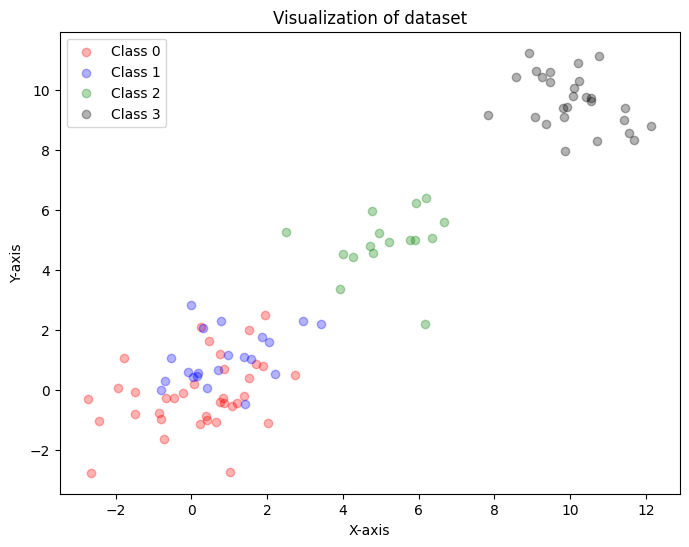

In [ ]:
D_train, L_train = generate_samples(100)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
visualize_samples(D_train, L_train, ax1)
plt.title('Visualization of dataset')
plt.show()

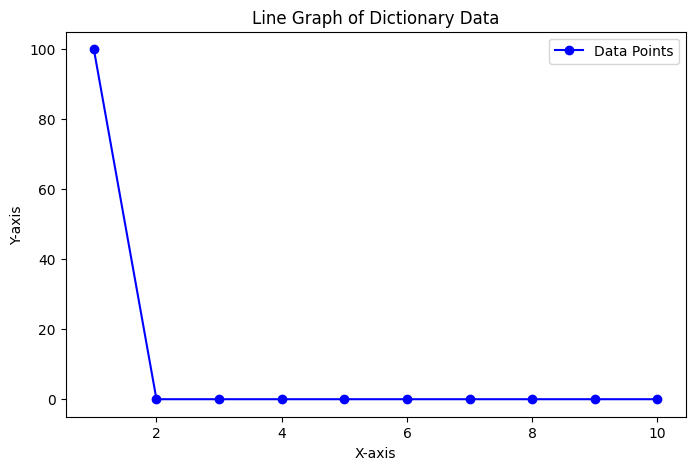

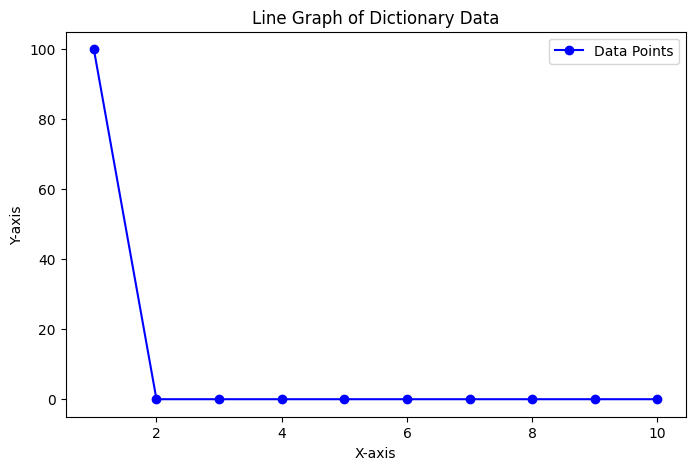

In [ ]:
order_dict_scratch = {key: 0 for key in range(1, 11, 1)}
order_dict_inbuilt = {key: 0 for key in range(1, 11, 1)}
for _ in range(100):
  D_train, L_train = generate_samples(10)

  # fig = plt.figure(figsize=(8, 6))
  # ax1 = fig.add_subplot(111)
  # visualize_samples(D_train, L_train, ax1)
  # plt.title('Visualization of dataset')
  # plt.show()

  n_splits = 10
  X, y = D_train, L_train

  max_ll_scratch = float('-inf')
  max_ll_inbuilt = float('-inf')
  max_order_scratch = 0
  max_order_inbuilt = 0
  for k in range(1, 7, 1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    ll_scratch = []
    ll_inbuilt = []
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      ll_scratch.append(log_likelihood_test_scratch(X_train, X_test, k))
      ll_inbuilt.append(log_likelihood_test_inbuilt(X_train, X_test, k))
    ll_scratch_avg = np.mean(ll_scratch)
    ll_inbuilt_avg = np.mean(ll_inbuilt)
    # print(f'Average test log likelihood for {n_splits} cross-validation for {k} order GMM: {ll_avg}')
    if ll_scratch_avg > max_ll_scratch:
      max_ll_scratch = ll_scratch_avg
      max_order_scratch = k
    if ll_inbuilt_avg > max_ll_inbuilt:
      max_ll_inbuilt = ll_inbuilt_avg
      max_order_inbuilt = k
  order_dict_scratch[max_order_scratch] += 1
  order_dict_inbuilt[max_order_inbuilt] += 1
  # print(f'Order which fits the most: {max_order}')

plot_final(order_dict_scratch)
plot_final(order_dict_inbuilt)

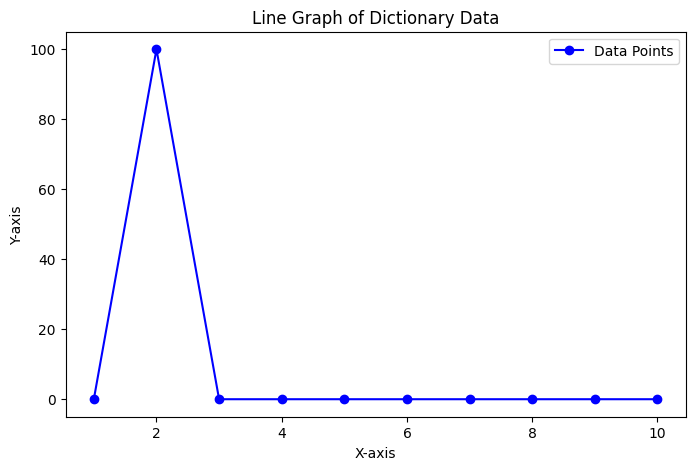

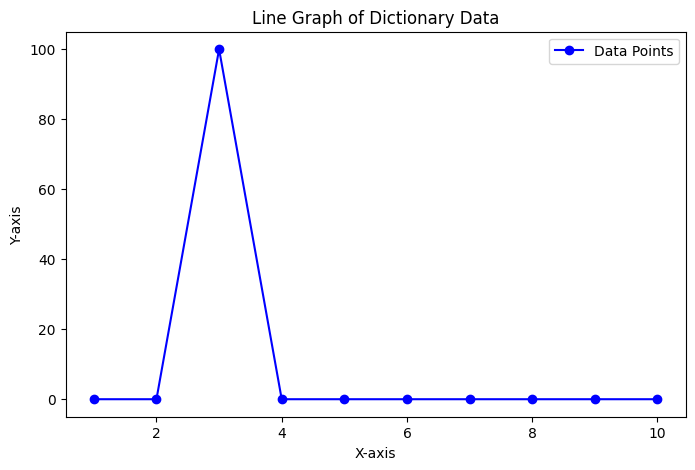

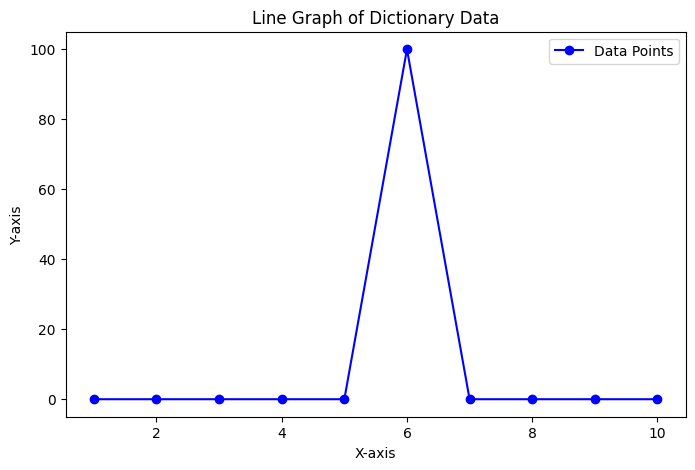

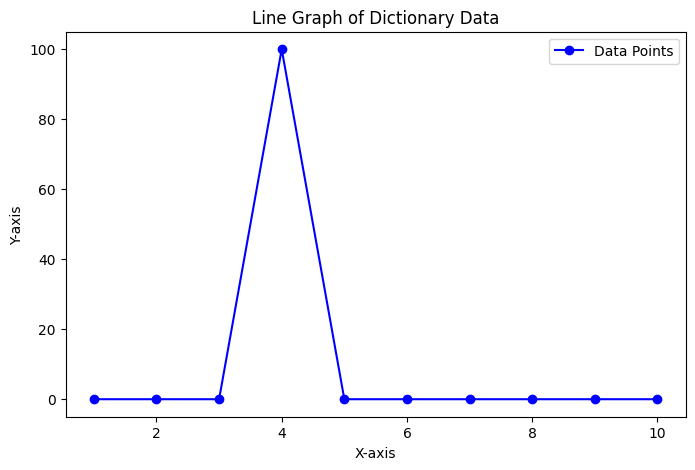

In [ ]:
for n_samples in [100, 1000]:
  order_dict_scratch = {key: 0 for key in range(1, 11, 1)}
  order_dict_inbuilt = {key: 0 for key in range(1, 11, 1)}
  for _ in range(100):
    D_train, L_train = generate_samples(n_samples)

    # fig = plt.figure(figsize=(8, 6))
    # ax1 = fig.add_subplot(111)
    # visualize_samples(D_train, L_train, ax1)
    # plt.title('Visualization of dataset')
    # plt.show()

    n_splits = 10
    X, y = D_train, L_train

    max_ll_scratch = float('-inf')
    max_ll_inbuilt = float('-inf')
    max_order_scratch = 0
    max_order_inbuilt = 0
    for k in range(1, 11, 1):
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
      ll_scratch = []
      ll_inbuilt = []
      for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ll_scratch.append(log_likelihood_test_scratch(X_train, X_test, k))
        ll_inbuilt.append(log_likelihood_test_inbuilt(X_train, X_test, k))
      ll_scratch_avg = np.mean(ll_scratch)
      ll_inbuilt_avg = np.mean(ll_inbuilt)
      # print(f'Average test log likelihood for {n_splits} cross-validation for {k} order GMM: {ll_avg}')
      if ll_scratch_avg > max_ll_scratch:
        max_ll_scratch = ll_scratch_avg
        max_order_scratch = k
      if ll_inbuilt_avg > max_ll_inbuilt:
        max_ll_inbuilt = ll_inbuilt_avg
        max_order_inbuilt = k
    order_dict_scratch[max_order_scratch] += 1
    order_dict_inbuilt[max_order_inbuilt] += 1
    # print(f'Order which fits the most: {max_order}')

  plot_final(order_dict_scratch)
  plot_final(order_dict_inbuilt)